In [1]:
%load_ext watermark
%watermark

Last updated: 2025-02-21T19:28:47.337856-05:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.30.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit



In [2]:
import time

import jax
import jax.numpy as jnp
import jaxlib
import jaxopt
import numpy as np
import pandas as pd

import pymedm
from pymedm.diagnostics import moe_fit_rate

jax.config.update("jax_enable_x64", True)

%watermark -w
%watermark -iv

Watermark: 2.5.0

jax   : 0.4.31
numpy : 2.2.3
pandas: 2.2.3
jaxlib: 0.4.31
pymedm: 2.2.3.dev4+g5dada73
jaxopt: 0.8.3



In [3]:
pymedm.processor_availability()

,device,available,count
0,cpu,True,1
1,gpu,False,0
2,tpu,False,0


## Individual Constraints

In [4]:
cind = pd.read_csv("../data/knox/cind_4701603.csv.gz")
cind.head()

,SERIALNO,population,group_quarters_pop,housing_units,occhu,civ_noninst_pop,male_hours_GE35,male_hours_15.34,male_hours_1.14,female_hours_GE35,...,txv_own_02_vehicle,txv_own_03_vehicle,txv_own_04_vehicle,txv_own_GE05_vehicle,txv_rent_no_vehicle,txv_rent_01_vehicle,txv_rent_02_vehicle,txv_rent_03_vehicle,txv_rent_04_vehicle,txv_rent_GE05_vehicle
0,2015000000763,2.760000,0.0,1,1,2.760000,1.0,0.0,0.0,0.000000,...,False,False,False,False,False,True,False,False,False,False
1,2015000001743,2.714286,0.0,1,1,2.714286,1.0,0.0,0.0,0.928571,...,False,True,False,False,False,False,False,False,False,False
2,2015000004434,5.875000,0.0,1,1,5.875000,1.0,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
3,2015000010209,2.177419,0.0,1,1,2.177419,0.0,0.0,0.0,0.000000,...,False,False,False,False,True,False,False,False,False,False
4,2015000011609,1.000000,1.0,0,0,1.000000,0.0,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False


In [5]:
## response IDs
serial = cind.SERIALNO.values

In [6]:
cind = cind.drop("SERIALNO", axis=1)

In [7]:
## sample weights
wt = pd.read_csv("../data/knox/wt_4701603.csv.gz", index_col=0).values.flatten()
wt

array([25., 14.,  8., ..., 10.,  9., 43.], shape=(5017,))

### Geographic Constraints

In [8]:
cg2 = pd.read_csv("../data/knox/cg2_4701603.csv.gz", index_col=0)
cg2.head()

,population,group_quarters_pop,housing_units,occhu,civ_noninst_pop,male_hours_GE35,male_hours_15.34,male_hours_1.14,female_hours_GE35,female_hours_15.34,...,txv_own_02_vehicle,txv_own_03_vehicle,txv_own_04_vehicle,txv_own_GE05_vehicle,txv_rent_no_vehicle,txv_rent_01_vehicle,txv_rent_02_vehicle,txv_rent_03_vehicle,txv_rent_04_vehicle,txv_rent_GE05_vehicle
GEOID,,,,,,,,,,,,,,,,,,,,,
470930001001,2463,236,1837,1603,2282,686,265,68,484,115,...,180,4,0,0,355,710,144,8,11,0
470930008001,1697,7,1031,831,1659,305,195,72,243,170,...,19,10,0,0,146,309,162,125,17,0
470930008002,574,88,279,233,486,69,16,0,182,53,...,6,31,0,0,0,83,80,0,0,0
470930008003,1336,151,467,401,1336,251,245,0,225,37,...,48,0,0,40,8,58,76,68,69,0
470930009011,1965,1958,4,4,1965,68,351,142,145,380,...,0,0,0,0,0,4,0,0,0,0


In [9]:
cg1 = pd.read_csv("../data/knox/cg1_4701603.csv.gz", index_col=0)
cg1.head()

,population,group_quarters_pop,housing_units,occhu,civ_noninst_pop,male_hours_GE35,male_hours_15.34,male_hours_1.14,female_hours_GE35,female_hours_15.34,...,txv_own_02_vehicle,txv_own_03_vehicle,txv_own_04_vehicle,txv_own_GE05_vehicle,txv_rent_no_vehicle,txv_rent_01_vehicle,txv_rent_02_vehicle,txv_rent_03_vehicle,txv_rent_04_vehicle,txv_rent_GE05_vehicle
GEOID,,,,,,,,,,,,,,,,,,,,,
47093000100,2463,236,1837,1603,2282,686,265,68,484,115,...,180,4,0,0,355,710,144,8,11,0
47093000800,3607,246,1777,1465,3481,625,456,72,650,260,...,73,41,0,40,154,450,318,193,86,0
47093000901,1965,1958,4,4,1965,68,351,142,145,380,...,0,0,0,0,0,4,0,0,0,0
47093000902,3034,2581,66,39,3034,341,528,242,207,537,...,0,0,0,0,0,15,0,5,0,19
47093001400,2447,0,1069,791,2447,307,42,10,254,115,...,85,57,10,0,180,252,82,35,0,0


In [10]:
sg2 = pd.read_csv("../data/knox/sg2_4701603.csv.gz", index_col=0)
sg2.head()

,population,group_quarters_pop,housing_units,occhu,civ_noninst_pop,male_hours_GE35,male_hours_15.34,male_hours_1.14,female_hours_GE35,female_hours_15.34,...,txv_own_02_vehicle,txv_own_03_vehicle,txv_own_04_vehicle,txv_own_GE05_vehicle,txv_rent_no_vehicle,txv_rent_01_vehicle,txv_rent_02_vehicle,txv_rent_03_vehicle,txv_rent_04_vehicle,txv_rent_GE05_vehicle
GEOID,,,,,,,,,,,,,,,,,,,,,
470930001001,137.993921,62.613982,49.848024,66.869301,122.796353,82.674772,68.085106,34.650456,68.693009,44.376900,...,45.592705,4.255319,7.294833,7.294833,42.553191,74.772036,35.258359,8.510638,11.550152,7.294833
470930008001,203.039514,9.118541,76.595745,72.340426,198.784195,88.145897,76.595745,43.768997,58.358663,68.693009,...,13.373860,9.118541,7.294833,7.294833,48.632219,60.182371,55.927052,44.984802,11.550152,7.294833
470930008002,142.857143,52.887538,52.279635,46.808511,130.699088,24.316109,11.550152,7.294833,47.416413,37.082067,...,6.079027,20.668693,7.294833,7.294833,7.294833,25.531915,35.866261,7.294833,7.294833,7.294833
470930008003,272.340426,136.778116,64.437690,64.437690,272.340426,79.027356,114.285714,7.294833,91.185410,26.139818,...,26.747720,7.294833,7.294833,21.884498,7.294833,28.571429,32.218845,42.553191,37.082067,7.294833
470930009011,181.762918,181.762918,3.039514,3.039514,181.762918,46.200608,55.319149,57.142857,48.632219,110.030395,...,7.294833,7.294833,7.294833,7.294833,7.294833,3.039514,7.294833,7.294833,7.294833,7.294833


In [11]:
sg1 = pd.read_csv("../data/knox/sg1_4701603.csv.gz", index_col=0)
sg1.head()

,population,group_quarters_pop,housing_units,occhu,civ_noninst_pop,male_hours_GE35,male_hours_15.34,male_hours_1.14,female_hours_GE35,female_hours_15.34,...,txv_own_02_vehicle,txv_own_03_vehicle,txv_own_04_vehicle,txv_own_GE05_vehicle,txv_rent_no_vehicle,txv_rent_01_vehicle,txv_rent_02_vehicle,txv_rent_03_vehicle,txv_rent_04_vehicle,txv_rent_GE05_vehicle
GEOID,,,,,,,,,,,,,,,,,,,,,
47093000100,137.993921,62.613982,49.848024,66.869301,122.796353,82.674772,68.085106,34.650456,68.693009,44.376900,...,45.592705,4.255319,7.294833,7.294833,42.553191,74.772036,35.258359,8.510638,11.550152,7.294833
47093000800,330.091185,151.367781,35.258359,79.635258,316.109422,121.580547,136.778116,43.768997,119.756839,84.498480,...,29.179331,21.884498,7.294833,21.884498,49.240122,70.516717,66.869301,61.398176,39.513678,7.294833
47093000901,181.762918,181.762918,3.039514,3.039514,181.762918,46.200608,55.319149,57.142857,48.632219,110.030395,...,7.294833,7.294833,7.294833,7.294833,7.294833,3.039514,7.294833,7.294833,7.294833,7.294833
47093000902,713.069909,652.279635,23.100304,20.060790,713.069909,99.696049,164.741641,82.066869,121.580547,158.662614,...,7.294833,7.294833,7.294833,7.294833,7.294833,15.197568,7.294833,4.255319,7.294833,14.589666
47093001400,221.276596,7.294833,62.613982,64.437690,221.276596,82.066869,26.747720,10.334347,62.006079,55.319149,...,27.355623,23.708207,10.334347,7.294833,56.534954,51.671733,35.866261,21.884498,7.294833,7.294833


## Setup P-MEDM Problem

<div class="alert alert-block alert-warning">
<b>Usage:</b>
    <br>• Setting 'n_reps >= 1' triggers the replicate generation workflow, which runs 'compute_hessian_matrix()'.
    <br>• The Hessian Matrix functionality within that function is highly experimental and not mature.
    <br>• Use with caution.
    <br>• Results are not guaranteed.
</div>

In [12]:
pmd = pymedm.PMEDM(
    2019,
    serial,
    wt,
    cind,
    cg1,
    cg2,
    sg1,
    sg2,
    include_cg0=False,
    n_reps=30,
    verbose=True,
)

In [13]:
start_time = time.time()
pmd.solve()
exec_time = np.round(time.time() - start_time, 4)
print(f"\nCompleted in {exec_time} seconds.")

Initializing P-MEDM solver...
P-MEDM completed in 34.0842 seconds.

Generating 30 replicates of the allocation matrix. The Hessian Matrix functionality here is highly experimental and not mature. Use with caution.

Replicates generated in 248.0075 seconds.

Completed in 282.1733 seconds.


## Validation

In [14]:
moe_fit_rate(cind, cg2, sg2, pmd.almat)

{'Ycomp':                            variable   acs        pmedm         err    moe  \
 470930001001             population  2463  2405.418530   57.581470  227.0   
 470930008001             population  1697  1595.113519  101.886481  334.0   
 470930008002             population   574   559.190974   14.809026  235.0   
 470930008003             population  1336  1208.328963  127.671037  448.0   
 470930009011             population  1965  1614.871076  350.128924  299.0   
 ...                             ...   ...          ...         ...    ...   
 470930070001  txv_rent_GE05_vehicle    36    23.524406   12.475594   55.0   
 470930070002  txv_rent_GE05_vehicle     0     0.838932    0.838932   12.0   
 470930071001  txv_rent_GE05_vehicle     0     0.645738    0.645738   12.0   
 470930071002  txv_rent_GE05_vehicle     0     0.212239    0.212239   12.0   
 470930071003  txv_rent_GE05_vehicle     0     0.270057    0.270057   12.0   
 
               in_moe  
 470930001001    True  
 4709

## Allocation Matrix Replicates

### Coefficient of Variation: allocation ests

In [15]:
sim_almats = np.array(pmd.almat_reps)

In [16]:
almat_cv = np.std(sim_almats, axis=0) / np.mean(sim_almats, axis=0)

<Axes: ylabel='Frequency'>

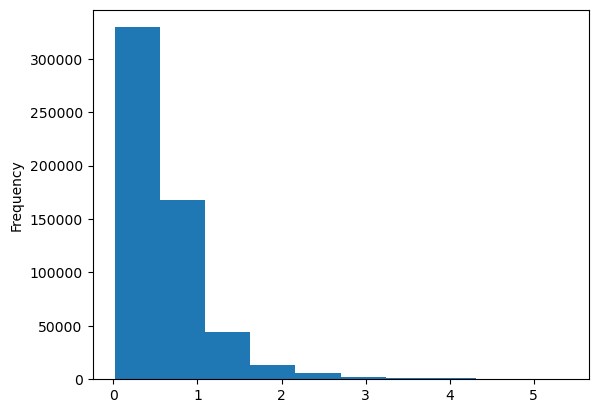

In [17]:
pd.Series(almat_cv.flatten()).plot.hist()

In [18]:
almat_cv.mean()

np.float64(0.5911426239252777)

In [19]:
np.median(almat_cv)

np.float64(0.4742046585190866)

### Variation in allocation ests - single cell

In [20]:
rep_ests_onecell = [sim_almats[i][0][15] for i in range(sim_almats.shape[0])]

<Axes: ylabel='Frequency'>

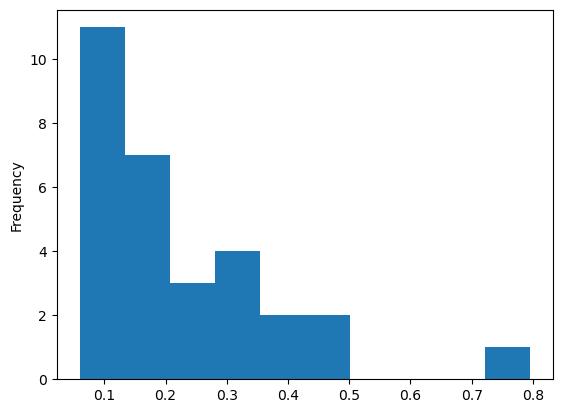

In [21]:
pd.Series(rep_ests_onecell).plot.hist()

### Bootstrapped MOE fit rates

In [22]:
sim_ests = pd.DataFrame()

In [23]:
for s in range(pmd.n_reps):
    _est = moe_fit_rate(cind, cg2, sg2, sim_almats[s])["Ycomp"]
    _est["sim"] = s

    sim_ests = pd.concat([sim_ests, _est], axis=0)

In [24]:
sim_ests.index.name = "geoid"

In [25]:
sim_ests

,variable,acs,pmedm,err,moe,in_moe,sim
geoid,,,,,,,
470930001001,population,2463,2289.303875,173.696125,227.0,True,0
470930008001,population,1697,1703.797871,6.797871,334.0,True,0
470930008002,population,574,655.605624,81.605624,235.0,True,0
470930008003,population,1336,1334.442183,1.557817,448.0,True,0
470930009011,population,1965,2310.930080,345.930080,299.0,False,0
...,...,...,...,...,...,...,...
470930070001,txv_rent_GE05_vehicle,36,20.401315,15.598685,55.0,True,29
470930070002,txv_rent_GE05_vehicle,0,0.830097,0.830097,12.0,True,29
470930071001,txv_rent_GE05_vehicle,0,0.235802,0.235802,12.0,True,29


In [26]:
sim_ests = sim_ests.reset_index()

In [27]:
sim_ests.head()

,geoid,variable,acs,pmedm,err,moe,in_moe,sim
0,470930001001,population,2463,2289.303875,173.696125,227.0,True,0
1,470930008001,population,1697,1703.797871,6.797871,334.0,True,0
2,470930008002,population,574,655.605624,81.605624,235.0,True,0
3,470930008003,population,1336,1334.442183,1.557817,448.0,True,0
4,470930009011,population,1965,2310.930080,345.930080,299.0,False,0


<Axes: ylabel='Frequency'>

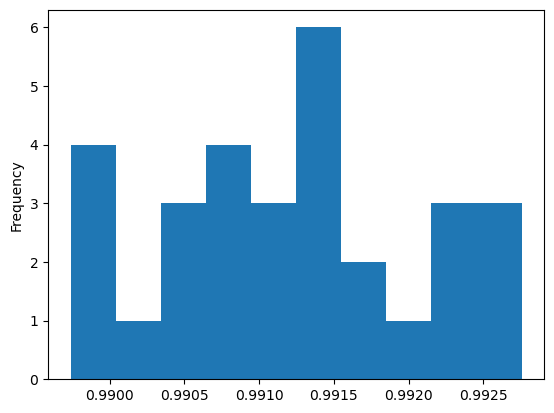

In [28]:
sim_ests.groupby("sim")["in_moe"].apply(lambda x: x.sum() / len(x)).plot.hist()

#### Bootstrapped Estimates

In [29]:
Yhat_boot = (
    sim_ests.groupby(["geoid", "variable"])["pmedm"]
    .aggregate(["mean", "std"])
    .reset_index()
)

In [30]:
Yhat_boot.head()

,geoid,variable,mean,std
0,470930001001,civ_noninst_pop,2340.513280,72.710142
1,470930001001,cmt_mins_10.14,218.850897,11.399881
2,470930001001,cmt_mins_15.19,242.125792,13.715544
3,470930001001,cmt_mins_20.24,185.083996,12.138043
4,470930001001,cmt_mins_25.29,119.995495,8.694470


In [31]:
Yhat_boot = Yhat_boot.rename({"mean": "est", "std": "se"}, axis=1)

In [32]:
Yhat_boot["cv"] = Yhat_boot.se / Yhat_boot.est

<Axes: ylabel='Frequency'>

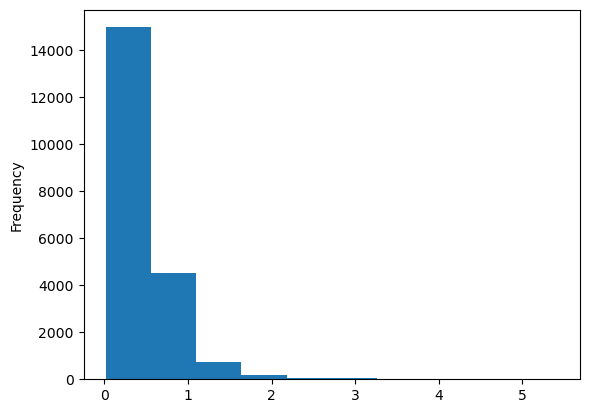

In [33]:
Yhat_boot.cv.plot.hist()

In [34]:
Yhat_boot.cv.mean()

np.float64(0.43281335572030505)

In [35]:
Yhat_boot.cv.median()

np.float64(0.30754398559009855)

In [36]:
Yhat_boot[Yhat_boot.cv >= 1]

,geoid,variable,est,se,cv
18,470930001001,grade_11th,2.875290,3.360780,1.168849
31,470930001001,grade_preschl,5.566846,8.344666,1.498993
44,470930001001,sch_female_09.12_private,1.824982,2.569075,1.407727
48,470930001001,sch_female_kind_private,0.236546,0.324253,1.370779
51,470930001001,sch_female_pre_public,1.202570,2.783630,2.314734
...,...,...,...,...,...
20505,470930071003,sexocc_female_law.enf,0.134581,0.169238,1.257517
20528,470930071003,sexocc_male_fff,0.002560,0.002973,1.161520
20530,470930071003,sexocc_male_law.enf,1.437295,1.793418,1.247773
20546,470930071003,travel_motorcycle,0.444743,0.527995,1.187192


<Axes: ylabel='Frequency'>

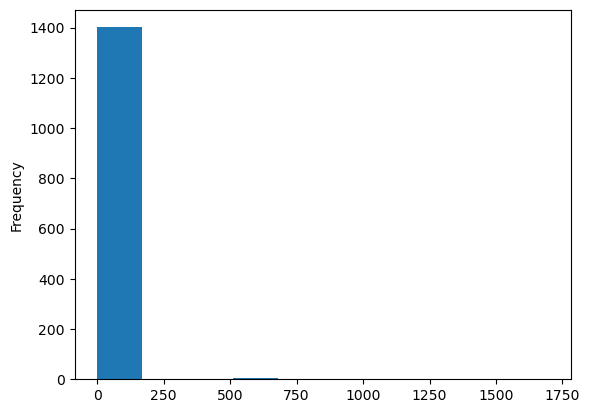

In [37]:
Yhat_boot[Yhat_boot.cv >= 1].est.plot.hist()

In [38]:
Yhat_boot[(Yhat_boot.cv >= 1) & (Yhat_boot.est >= 10)]

,geoid,variable,est,se,cv
762,470930009011,housing_units,16.100689,18.023780,1.119442
765,470930009011,male_hours_GE35,61.096120,91.087455,1.490888
766,470930009011,occhu,15.883103,17.944403,1.129779
787,470930009011,sch_male_09.12_public,10.447617,50.284219,4.812985
805,470930009011,sexcw_male_local.gov,12.290783,34.531178,2.809518
833,470930009011,sexnaics_male_prf,17.319148,25.886821,1.494694
865,470930009011,sexocc_male_cmp,19.246795,25.491579,1.324458
877,470930009011,sexocc_male_med.tech,15.229283,38.030933,2.497224
923,470930009021,emp_stat_unemp,11.376064,16.523071,1.452442
941,470930009021,grade_preschl,14.643653,51.079432,3.488162


#### Compare to ACS uncertainty levels

In [39]:
sim_ests.head()

,geoid,variable,acs,pmedm,err,moe,in_moe,sim
0,470930001001,population,2463,2289.303875,173.696125,227.0,True,0
1,470930008001,population,1697,1703.797871,6.797871,334.0,True,0
2,470930008002,population,574,655.605624,81.605624,235.0,True,0
3,470930008003,population,1336,1334.442183,1.557817,448.0,True,0
4,470930009011,population,1965,2310.930080,345.930080,299.0,False,0


In [40]:
acs_cv = (sim_ests[sim_ests.sim == 0].moe / 1.645) / sim_ests[sim_ests.sim == 0].acs

In [41]:
acs_cv[~acs_cv.isin([np.inf])].mean()

np.float64(0.6715387773908736)

In [42]:
acs_cv[~acs_cv.isin([np.inf])].median()

np.float64(0.6754474839581225)

<Axes: ylabel='Frequency'>

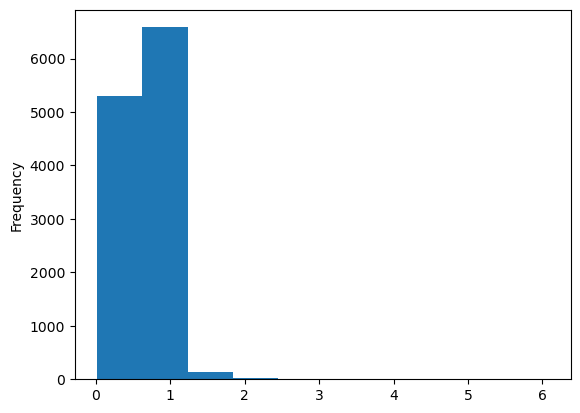

In [43]:
acs_cv[~acs_cv.isin([np.inf])].plot.hist()